# Benchmark ComBind on PDB ligands

In [1]:
import numpy as np
import os
from glob import glob
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
data = {} # mode, (alpha, features), protein, ligand, scores
with open('/Users/jpaggi/Downloads/combind_data/bpp_outputs/stats6_best_affinity.tsv') as fp:
    print fp.readline()
    for line in fp:
        if 'None' in line: continue
        (mode, protein, ligand, num_ligs, alpha, features, _, combind_rmsd,
         _, glide_rmsd, _, best_rmsd) = line.strip().split('\t')
        alpha, combind_rmsd,glide_rmsd, best_rmsd = float(alpha), float(combind_rmsd),float(glide_rmsd), float(best_rmsd)
        num_ligs = int(num_ligs)
        if mode not in data: data[mode] = {}
        k = (num_ligs, alpha, features)
        if k not in data[mode]: data[mode][k] = {}
        if protein not in data[mode][k]: data[mode][k][protein] = {}
        data[mode][k][protein][ligand] = (float(combind_rmsd), float(glide_rmsd), float(best_rmsd))

mode	protein	ligand	n_ligs	alpha	features	combind_rank	combind_rmsd	glide_rank	glide_rmsd	best_rank	best_rmsd



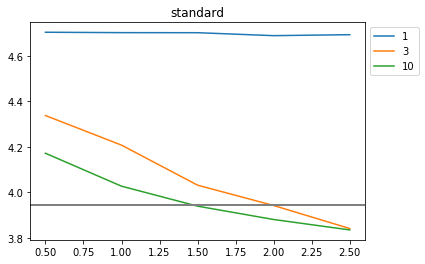

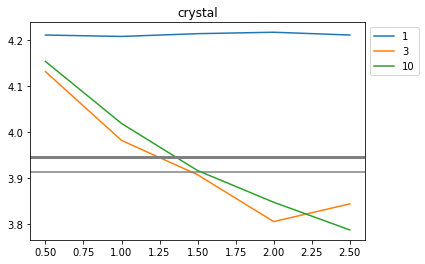

In [27]:
def performance(results):
    x, y = [], []
    for prot, ligs in results.items():
        for lig, (combind, glide, best) in ligs.items():
            x += [glide]
            y += [combind]
    
    return (sum(x) / float(len(x)), sum(np.array(x) <= 2.0) /  float(len(x)),
            sum(y) / float(len(y)), sum(np.array(y) <= 2.0) /  float(len(y)))

def sweep(data, mode, feature):
    num_ligs = sorted(set(k[0] for k in data[mode].keys()))
    alpha_factors = sorted(set(k[1] for k in data[mode].keys()))
    for n in [1, 3, 10]: #num_ligs:
        performances = []
        for alpha_factor in alpha_factors:
            performances += [performance(data[mode][(n, alpha_factor, feature)])]
        plt.plot(alpha_factors, [p[2] for p in performances], label = n)
        for p in performances:
            plt.axhline(p[0], c = 'grey')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(mode)
    plt.show()

sweep(data, 'standard', 'pipi_contact_hbond_sb')
sweep(data, 'crystal',  'pipi_contact_hbond_sb')

In [20]:
thresh = 2.0
def benchmark(results):
    tot = 0
    for prot, ligs in results.items():
        print prot, len(ligs)
        tot += len(ligs)
    print tot
        
    x, y = [], []
    for prot, ligs in results.items():
        for lig, (combind, glide, best) in ligs.items():
            x += [glide]
            y += [combind]

    # All ligands separately
    print ttest_rel(x, y)
    
    print 'Combind improves pose for {} of {} ligands'.format(np.sum(np.array(x) > np.array(y)+.5),
                                                              len(x))
    print 'Combind degrades pose for {} of {} ligands'.format(np.sum(np.array(x)+.5 < np.array(y)),
                                                              len(x))

    
    f, ax = plt.subplots()
    plt.scatter(x, y, alpha = 0.5, s = 10)
    plt.xlabel('Glide', fontsize = 16)
    plt.ylabel('ComBind', fontsize = 16)
    plt.title('All Ligands RMSD', fontsize = 20)
    plt.xlim(0, 15)
    plt.ylim(0, 15)
    plt.xticks(range(0, 15, 2), range(0, 15, 2))
    ax.set_aspect('equal', 'box')
    print 'Glide Average:  ', sum(x) / float(len(x)), sum(np.array(x) <= thresh) /  float(len(x))
    print 'ComBind Average:', sum(y) / float(len(y)), sum(np.array(y) <= thresh) /  float(len(y))
    plt.show()

    # By Protein (RMSD)
    x, y, label = [], [], []
    for prot, ligs in results.items():
        _x, _y = [], []
        for lig, (combind, glide, best) in ligs.items():
            _x += [glide]
            _y += [combind]
        label += [prot]
        x += [sum(_x)/float(len(_x))]
        y += [sum(_y)/float(len(_y))]

    markers = ['o', 'v', 'x', 's']
    f, ax = plt.subplots()
    for i, (_x, _y, _label) in enumerate(zip(x, y, label)):
        plt.scatter(_x, _y, marker = markers[i/10], label = _label)
    plt.xlabel('Glide', fontsize = 16)
    plt.ylabel('ComBind', fontsize = 16)
    plt.title('Mean RMSD', fontsize = 20)
    plt.plot(range(10), linestyle='--', c = 'k')
    ax.set_aspect('equal', 'box')
    print 'Mean RMSD Glide:   ', sum(x) / float(len(x))
    print 'Mean RMSD Combind: ', sum(y) / float(len(y))
    plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=3)
    plt.show()
    
    # By protein (% correct)
    x, y = [], []
    for prot, ligs in results.items():
        _x, _y = [], []
        for lig, (combind, glide, best) in ligs.items():
            _x += [glide <= thresh]
            _y += [combind <= thresh]
        label += [prot]
        x += [sum(_x)/float(len(_x))]
        y += [sum(_y)/float(len(_y))]

    markers = ['o', 'v', 'x', 's']
    f, ax = plt.subplots()
    for i, (_x, _y, _label) in enumerate(zip(x, y, label)):
        plt.scatter(_x, _y, marker = markers[i/10], label = _label)
    plt.xlabel('Glide', fontsize = 16)
    plt.ylabel('ComBind', fontsize = 16)
    plt.plot(range(2), linestyle='--', c = 'k')
    plt.title('Fraction Near-Native', fontsize = 20)
    ax.set_aspect('equal', 'box')
    print 'Fraction Near-Native Glide:   ', sum(x) / float(len(x))
    print 'Fraction Near-Native Combind: ',sum(y) / float(len(y))
    plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=3)
    plt.show()

ELANE 8
VDR 20
5HT2B 5
SLC6A4 4
PLK1 11
MGLUR5 4
ERA 20
F10 20
GLUT1 2
SMO 4
DAT 8
MEK1 20
JAK2 20
TRPV1 1
PYGM 20
P00760 20
MAPK14 20
B2AR 7
NR3C1 18
NR3C2 11
PLAU 20
AR 10
BRD4 16
PTPN1 20
F11 13
PDE10A 20
A2AR 17
BACE1 20
F2 20
CHK1 20
CDK2 20
BRAF 20
HSP90AA1 20
B1AR 11
490
Ttest_relResult(statistic=2.164112589633012, pvalue=0.03093910586420422)
Combind improves pose for 72 of 490 ligands
Combind degrades pose for 51 of 490 ligands
Glide Average:   3.94508163833 0.448979591837
ComBind Average: 3.78771924437 0.465306122449


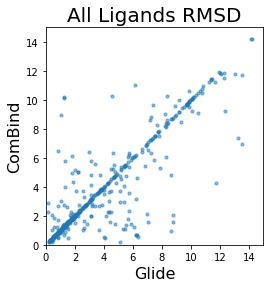

Mean RMSD Glide:    3.83403364747
Mean RMSD Combind:  3.63162267196


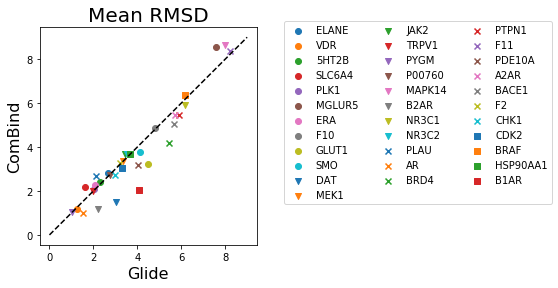

Fraction Near-Native Glide:    0.453717397078
Fraction Near-Native Combind:  0.480754481966


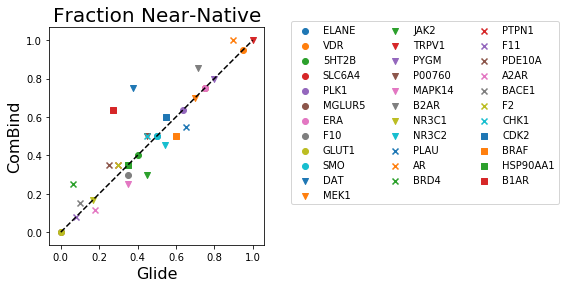

In [33]:
benchmark(data['crystal'][(10, 2.5, 'pipi_contact_hbond_sb')])